In [1]:
# Import libraries

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute, assemble
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit_ibm_provider import IBMProvider
from qiskit import Aer
from qiskit.quantum_info import Statevector, partial_trace, random_unitary
from numpy.random import randint, rand
from IPython.display import clear_output
from qiskit.extensions import Initialize
from statistics import mean, stdev, variance
from qiskit_aer.noise import NoiseModel, device
from qiskit_aer import QasmSimulator
import matplotlib.pyplot as plt
import numpy as np
from math import pi, sqrt
import time
from random import choice, sample
import random


IBMProvider.save_account(
    'b8880574a4a7e50ac6eb5ca65974a70cdc06ce7c4a59c276b0ffd0c44d44088035bd9b9ed6f002d33ed3380f32bcbae8aac026eec30de52943a6f19375e3b557',
    overwrite=True,
)
provider = IBMProvider()
shots = 1024
sim = provider.get_backend("ibmq_qasm_simulator")
backend = provider.get_backend("ibmq_lima")
# state_vector_sim = Aer.get_backend("statevector_simulator")

In [2]:
# function to create pure entangled states


def pure_estate(circuit, q0, q1):
    u1 = random_unitary(2)
    circuit.append(u1, [q0])
    circuit.cx(q0, q1)

    return circuit

In [3]:
###### Generating a random message

n = int(input("Length of message:"))
message = np.random.randint(2, size=n)
print(message)
nd = int(input("Number of decoy bits to be inserted:"))

Length of message:15
[1 0 1 0 0 1 0 1 1 1 0 1 0 1 0]
Number of decoy bits to be inserted:10


In [4]:
# Generating a list of possible states

states = ["0", "1", "+", "-"]

In [5]:
# Generating set of decoy photons

dq_st = []


def gen_decoy(i):
    dqu = QuantumCircuit(1)
    if i == "1" or i == "-":
        dqu.x(0)
    if i == "+" or i == "-":
        dqu.h(0)
    return dqu
    # dqu.save_statevetor()
    # dq.append(dqu)
    # result = state_vector_sim.run(dqu).result()
    # sv = result.get_statevector()
    # dq_st.append(sv)

In [6]:
# Attacks 0 ="", 1="EaM Attack", 2="IaR Attack", 3="DoS Attack"


# Entangle and measure attack
def EaM_attack_z(qc):
    """Create entanglement with qubits in the circuit."""
    num_qubits = qc.num_qubits
    if num_qubits == 1:
        e = QuantumRegister(1)
        e_cl = ClassicalRegister(1)
        qc.add_register(e)
        qc.add_register(e_cl)
        qc.cx(0, num_qubits)
        qc.measure(num_qubits, 0)
    else:
        e = QuantumRegister(1)
        qc.add_register(e)
        qc.cx(num_qubits - 1, num_qubits)
        qc.measure(num_qubits, 0)


def EaM_attack_x(qc):
    """Create entanglement with qubits in the circuit."""
    num_qubits = qc.num_qubits
    if num_qubits == 1:
        e = QuantumRegister(1)
        e_cl = ClassicalRegister(1)
        qc.add_register(e)
        qc.add_register(e_cl)
        qc.cx(0, num_qubits)
        qc.h(num_qubits)
        qc.measure(num_qubits, 0)
        qc.h(num_qubits)
    else:
        e = QuantumRegister(1)
        qc.add_register(e)
        qc.cx(num_qubits - 1, num_qubits)
        qc.h(num_qubits)
        qc.measure(num_qubits, 0)
        qc.h(num_qubits)


# Intercept and resend attack
def IaR_attack_z(qc):
    """Intercepts the qubits with measurement in Hadamard basis."""
    # print("Perform IaR attack")
    num_qubits = qc.num_qubits
    if num_qubits == 1:
        e_cl = ClassicalRegister(1)
        qc.add_register(e_cl)
    for i in range(qc.num_qubits):
        qc.measure(i, qc.num_clbits - 1)


def IaR_attack_x(qc):
    """Intercepts the qubits with measurement in Hadamard basis."""
    # print("Perform IaR attack")
    num_qubits = qc.num_qubits
    if num_qubits == 1:
        e_cl = ClassicalRegister(1)
        qc.add_register(e_cl)
    for i in range(qc.num_qubits):
        qc.h(i)
        qc.measure(i, qc.num_clbits - 1)
        qc.h(i)


# DoS attack
def DoS_attack(qc):
    """Randomly applies identity on Alice's qubit"""
    # print("Perform DOS attack")
    num_qubits = qc.num_qubits
    if num_qubits == 1:
        e_cl = ClassicalRegister(1)
        qc.add_register(e_cl)
    # 𝜃,𝜙,𝜆 varies between 0 and 2𝜋
    theta = 2 * pi * rand()
    phi = 2 * pi * rand()
    lamb = 2 * pi * rand()
    qc.u(theta, phi, lamb, random.randrange(num_qubits))

In [7]:
# function to apply any attack


def do_attack(qcl):
    print(
        "Types of attacks: 1. Entanglement and Measurement Attack. 2. Intercept and Resend Attack 3. Denial of Service Attack."
    )
    attack = input("\nEnter the type of attack you wish to implement:")
    if attack == "1":
        for i in range(n + nd):
            EaM_lst = [EaM_attack_z, EaM_attack_x]
            choice(EaM_lst)(qcl[i])

    elif attack == "2":
        for i in range(n + nd):
            IaR_lst = [IaR_attack_z, IaR_attack_x]
            choice(IaR_lst)(qcl[i])

    elif attack == "3":
        for i in range(n + nd):
            DoS_attack(qcl[i])

    return attack


# function to apply EaM attack
def do_attack1(qcl):
    for i in range(n + nd):
        EaM_lst = [EaM_attack_z, EaM_attack_x]
        choice(EaM_lst)(qcl[i])
    return "1"


# function to apply IaR attack
def do_attack2(qcl):
    for i in range(n + nd):
        IaR_lst = [IaR_attack_z, IaR_attack_x]
        choice(IaR_lst)(qcl[i])
    return "2"


# function to apply DoS attack
def do_attack3(qcl):
    for i in range(n + nd):
        DoS_attack(qcl[i])
    return "3"

In [19]:
# Step1:Creating n pure entangled states
def create_pest(m):
    pk = []
    for i in range(m):
        qr = QuantumRegister(2, "qb")
        cr = ClassicalRegister(1, "cb")
        circuit = QuantumCircuit(qr, cr)
        state = pure_estate(circuit, qr[0], qr[1])
        pk.append(state)
        # display(pk[i].draw('mpl'))
    return pk


private_key0 = create_pest(n)
# check eavesdropping by adding decoy photons at random position and printing the positions


def create_pkd(private_key, n, nd):
    pkd = []
    for i in range(n):
        pkd.append(private_key[i].copy())
    lst = [x for x in range(n + nd)]
    pos1 = sample(lst, nd)
    pos1.sort()
    rdq1 = []
    rdq_st1 = []
    for i in pos1:
        decoy_st1 = choice(states)
        decoy1 = gen_decoy(decoy_st1)
        rdq1.append(decoy1)
        rdq_st1.append(decoy_st1)
        decoy12 = decoy1.copy()
        pkd.insert(i, decoy12)
    print(pos1)
    return pkd, rdq_st1, pos1


pkd0, rdq_st10, pos10 = create_pkd(private_key0, n, nd)

[3, 5, 6, 8, 10, 13, 14, 19, 21, 24]


In [9]:
# for i in range(nd):
# result = state_vector_sim.run(rdq1[i]).result()
# sv = result.get_statevector()
# print(sv)
for i in range(nd):
    print(rdq_st10[i])

+
-
0
0
-
1
-
-
+
1


In [20]:
# Applying attack of choice on the sequence of pure entangled states with decoy photons

att1 = do_attack1(pkd0)

In [11]:
def noisy_meas_err_func(cc, rdq_st, j, shots, flag):
    err = 0
    err_c = 0
    a = list(cc.keys())
    a.sort()
    if "0" in cc and "1" not in cc:
        if flag == 0:
            if a[0] != "0":
                err = shots
                err_c += 1
        else:
            if rdq_st[j] == "-":
                err = shots
                err_c += 1
    elif "1" in cc and "0" not in cc:
        if flag == 0:
            if a[0] != "1":
                err = shots
                err_c += 1
        else:
            if rdq_st[j] == "+":
                err = shots
                err_c += 1
    if "0" in cc and "1" in cc:
        if flag == 0:
            if a[0] == rdq_st[j]:
                err = cc["1"]
                if cc["1"] > cc["0"] or abs(cc["0"] - cc["1"]) < 600:
                    err_c += 1
            elif a[1] == rdq_st[j]:
                err = cc["0"]
                if cc["0"] > cc["1"] or abs(cc["0"] - cc["1"]) < 600:
                    err_c += 1
        elif flag == 1:
            if rdq_st[j] == "+":
                err = cc["1"]
                if abs(cc["0"] - cc["1"]) < 600:
                    err_c += 1
            elif rdq_st[j] == "-":
                err = cc["0"]
                if abs(cc["0"] - cc["1"]) < 600:
                    err_c += 1

    return err, err_c

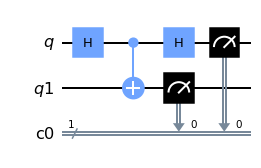

The measurements of the decoy photon at position 1 after the attack is: {'0': 506, '1': 518}


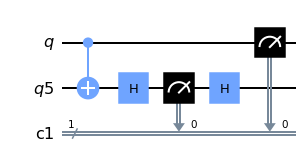

The measurements of the decoy photon at position 5 after the attack is: {'0': 1024}


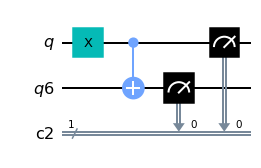

The measurements of the decoy photon at position 6 after the attack is: {'1': 1024}


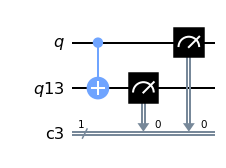

The measurements of the decoy photon at position 13 after the attack is: {'0': 1024}


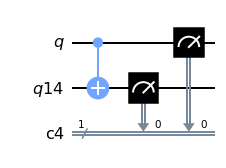

The measurements of the decoy photon at position 14 after the attack is: {'0': 1024}


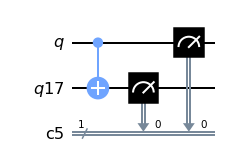

The measurements of the decoy photon at position 17 after the attack is: {'0': 1024}


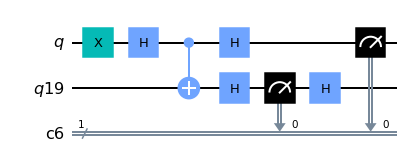

The measurements of the decoy photon at position 19 after the attack is: {'0': 513, '1': 511}


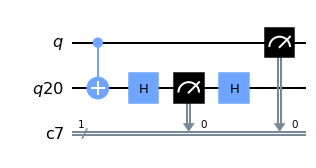

The measurements of the decoy photon at position 20 after the attack is: {'0': 1024}


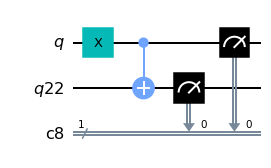

The measurements of the decoy photon at position 22 after the attack is: {'1': 1024}


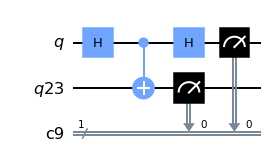

The measurements of the decoy photon at position 23 after the attack is: {'1': 525, '0': 499}
Error rate in measuring decoy photons: 15.1953125 %
The number of mismatched decoy photons is 3 and the error rate of trasmitting decoy photons: 30.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 41.16993999481201 seconds

Eavesdropper detected.


In [12]:
# Measuring the decoy photons inserted in sequence of pure entangled states in respective bases and finiding the errors

errors_for_first_check0 = []
errors_count_for_first_check0 = []


def check_eavesdropper1(
    pkd, rdq_st1, errors_for_first_check0, errors_count_for_first_check0, pos1
):
    j = 0
    err1 = 0
    err_rate1 = 0.0
    err_flag1 = 0
    err_count1 = 0
    err_count_rate1 = 0.0
    time01 = time.time()
    for i in pos1:
        flag = 0
        if rdq_st1[j] == "+" or rdq_st1[j] == "-":
            pkd[i].h(0)
            flag = 1
        pkd[i].measure(0, 0)
        rslt1 = execute(pkd[i], backend=sim, shots=shots).result()
        cc1 = rslt1.get_counts()
        k = list(cc1.keys())
        k.sort()
        display(pkd[i].draw("mpl"))
        print(
            "The measurements of the decoy photon at position",
            i,
            "after the attack is:",
            cc1,
        )
        err1, err_flag1 = noisy_meas_err_func(cc1, rdq_st1, j, shots, flag)
        err_count1 += err_flag1
        j = j + 1
        err_rate1 = err_rate1 + float((err1 / shots) * 100)
    time_1 = time.time() - time01
    hr1 = time_1 // 3600
    time_1 %= 3600
    err_rate1 = float(err_rate1 / nd)
    err_count_rate1 = float((err_count1 / nd) * 100)
    errors_for_first_check0.append(err_rate1)
    errors_count_for_first_check0.append(err_count_rate1)
    return err_count1, err_count_rate1, err_rate1, hr1, time_1


err_count1, err_count_rate1, err_rate1, hr1, time_1 = check_eavesdropper1(
    pkd0, rdq_st10, errors_for_first_check0, errors_count_for_first_check0, pos10
)
print(f"Error rate in measuring decoy photons: {err_rate1} %")
print(
    f"The number of mismatched decoy photons is {err_count1} and the error rate of trasmitting decoy photons: {err_count_rate1} %"
)
print(
    f"Time taken to measure {nd} decoy photons: {int(hr1)} hours {int(time_1//60)} minutes {time_1%60} seconds"
)
if err_count1 != 0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

In [21]:
# Step2:Creating a sequence of travelling qubits in Z basis


def create_tq(msg):
    tt = []
    for i in msg:
        t = QuantumCircuit(QuantumRegister(1))
        if i == 0:
            tt.append(t)
        else:
            t.x(0)
            tt.append(t)
    return tt


tq0 = create_tq(message)

In [22]:
# Step3: Encrypting the message using CNOT gate


def encrypt_mes(pk, tt, m):
    for i in range(m):
        pk[i].add_register(*tt[i].qregs)
        pk[i].barrier()
        pk[i]=pk[i].compose(tt[i], [pk[i].qubits[-1]])
        pk[i].cx(0, 2)
        #display(pk[i].draw("mpl"))


encrypt_mes(private_key0, tq0, n)


# inserting decoy photons in the sequence of travelling photons to check for eavesdropping
def insert_decoys2(private_key, nd):
    rdq_st2 = []
    lst = [x for x in range(n + nd)]
    pos2 = sample(lst, nd)
    pos2.sort()
    rdq2 = []
    for i in pos2:
        decoy_st2 = choice(states)
        decoy2 = gen_decoy(decoy_st2)
        rdq2.append(decoy2)
        rdq_st2.append(decoy_st2)
        decoy22 = decoy2.copy()
        private_key.insert(i, decoy22)
    print(pos2)
    return private_key, rdq_st2, pos2


private_key0, rdq_st20, pos20 = insert_decoys2(private_key0, nd)

[0, 1, 2, 3, 7, 9, 13, 14, 18, 23]


In [14]:
for i in range(nd):
    print(rdq_st20[i])

1
1
-
1
0
-
+
-
1
1


In [23]:
# Applying attack of choice on the sequence of travelling photons with decoy photons

att2 = do_attack1(private_key0)

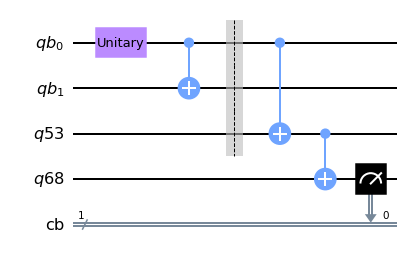

The measurements of the travelling photons after the attack is: {'1': 28, '0': 996}
0 0


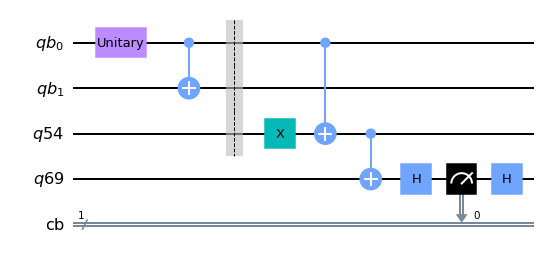

The measurements of the travelling photons after the attack is: {'1': 489, '0': 535}
-1 1


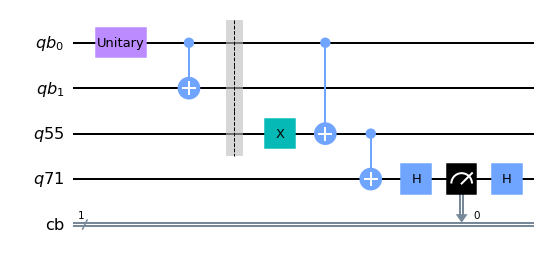

The measurements of the travelling photons after the attack is: {'0': 498, '1': 526}
-1 1


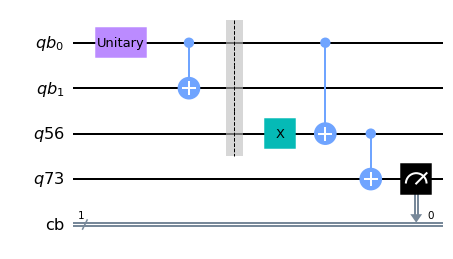

The measurements of the travelling photons after the attack is: {'1': 376, '0': 648}
0 1


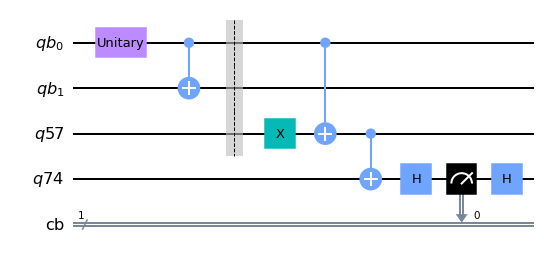

The measurements of the travelling photons after the attack is: {'0': 490, '1': 534}
-1 1


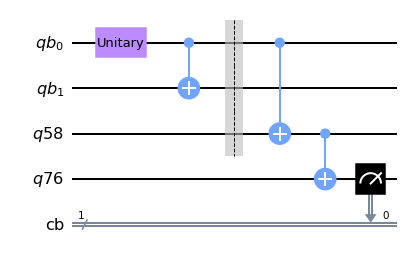

The measurements of the travelling photons after the attack is: {'0': 629, '1': 395}
0 0


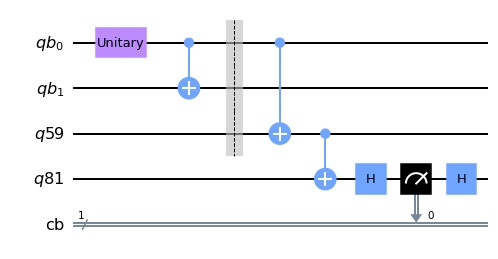

The measurements of the travelling photons after the attack is: {'1': 521, '0': 503}
-1 0


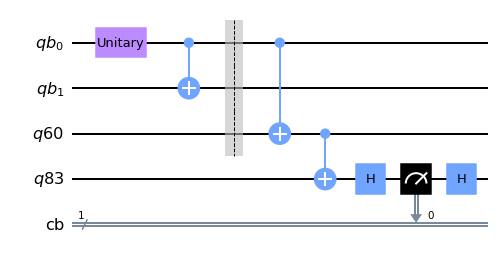

The measurements of the travelling photons after the attack is: {'1': 517, '0': 507}
-1 0


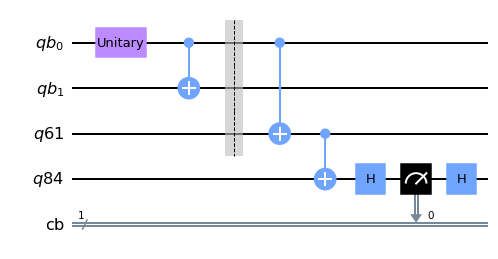

The measurements of the travelling photons after the attack is: {'1': 518, '0': 506}
-1 0


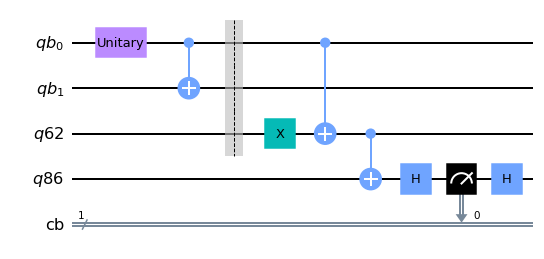

The measurements of the travelling photons after the attack is: {'1': 514, '0': 510}
-1 1


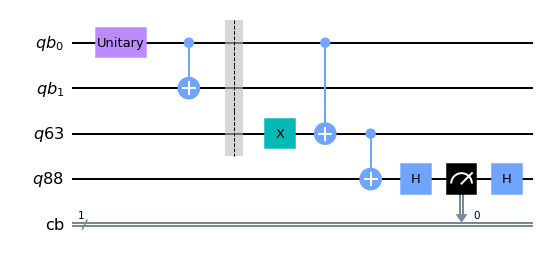

The measurements of the travelling photons after the attack is: {'1': 519, '0': 505}
-1 1


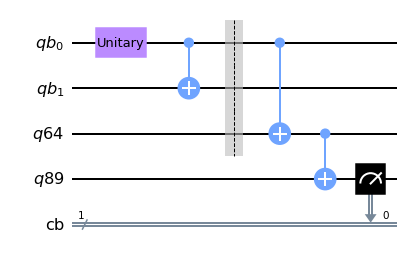

The measurements of the travelling photons after the attack is: {'1': 553, '0': 471}
-1 0


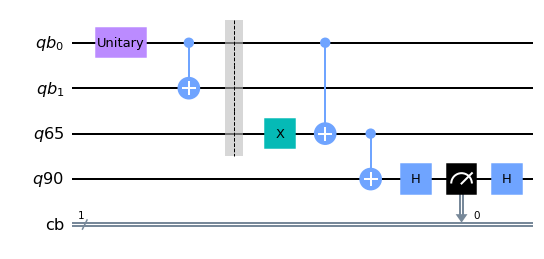

The measurements of the travelling photons after the attack is: {'1': 519, '0': 505}
-1 1


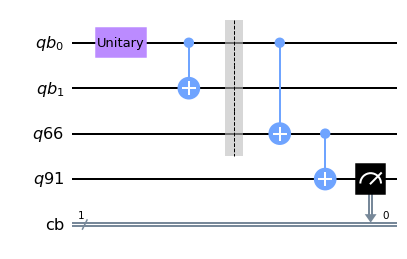

The measurements of the travelling photons after the attack is: {'1': 20, '0': 1004}
0 0


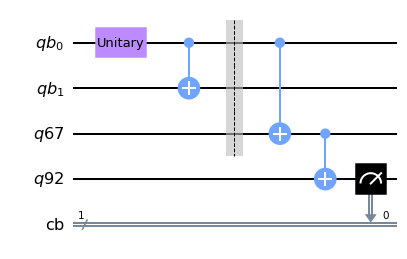

The measurements of the travelling photons after the attack is: {'0': 756, '1': 268}
0 0
The number of message bits leaked is 4 and the rate of message being leaked: 26.666666666666668 %
Time taken to measure 15 travelling photons entangled with pure entangled states: 0 hours 0 minutes 49.66248106956482 seconds


In [17]:
#Measuring the travelling photons to measure information leak

mssg_info_leak=[]
def measure_info_leak(pk,mssg_info_leak,pos2,mssg):
    j=0
    mssg_leak_c=0
    mssg_leak_rate=0.0
    time0 = time.time()
    for i in range(n+nd):
        if i not in pos2:
            rslt = execute(pk[i], backend=sim, shots=shots).result()
            cc = rslt.get_counts()
            display(pk[i].draw('mpl'))
            print("The measurements of the travelling photons after the attack is:",cc)
            rs=-1
            if '0' in cc and '1' not in cc:
                rs=0
            elif '1' in cc and '0' not in cc:
                rs=1
            if '0' in cc and '1' in cc:
                if cc['0']>cc['1'] and abs(cc['0']-cc['1'])>200:
                    rs=0
                if cc['0']<cc['1'] and abs(cc['0']-cc['1'])>200:
                    rs=1
            print(rs,mssg[j])
            if (rs==mssg[j]):
                mssg_leak_c+=1
            j=j+1
    time_ = time.time() - time0
    hr = time_//3600
    time_ %= 3600
    mssg_leak_rate=float((mssg_leak_c/n)*100)
    mssg_info_leak.append(mssg_leak_rate)
    return mssg_leak_c,mssg_leak_rate,hr,time_


if att2=='1' or att2=='2':
    mssg_leak_c,mssg_leak_rate,hr,time_=measure_info_leak(private_key0,mssg_info_leak,pos20,message)
    print(f"The number of message bits leaked is {mssg_leak_c} and the rate of message being leaked: {mssg_leak_rate} %")
    print(f'Time taken to measure {n} travelling photons entangled with pure entangled states: {int(hr)} hours {int(time_//60)} minutes {time_%60} seconds')

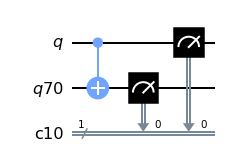

The measurements of the decoy photon at position 2 after the attack is: {'0': 1024}


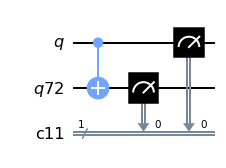

The measurements of the decoy photon at position 4 after the attack is: {'0': 1024}


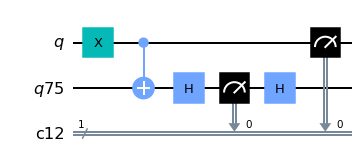

The measurements of the decoy photon at position 7 after the attack is: {'1': 1024}


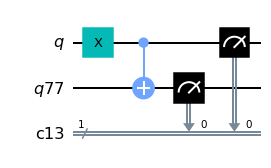

The measurements of the decoy photon at position 9 after the attack is: {'1': 1024}


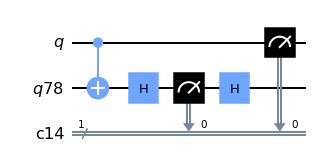

The measurements of the decoy photon at position 10 after the attack is: {'0': 1024}


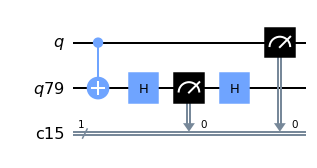

The measurements of the decoy photon at position 11 after the attack is: {'0': 1024}


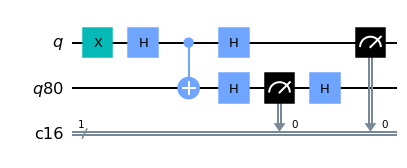

The measurements of the decoy photon at position 12 after the attack is: {'0': 529, '1': 495}


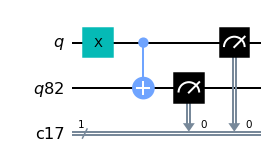

The measurements of the decoy photon at position 14 after the attack is: {'1': 1024}


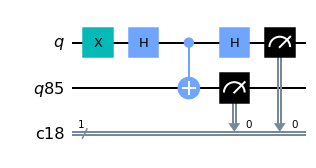

The measurements of the decoy photon at position 17 after the attack is: {'1': 539, '0': 485}


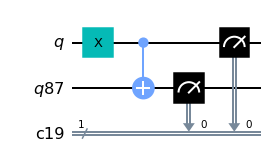

The measurements of the decoy photon at position 19 after the attack is: {'1': 1024}
Error rate in measuring decoy photons: 9.90234375 %
The number of mismatched decoy photons is 2 and the error rate of trasmitting decoy photons: 20.0 %
Time taken to measure 10 decoy photons: 0 hours 0 minutes 38.649022579193115 seconds

Eavesdropper detected.


In [18]:
# Measuring the decoy photons inserted in sequence of travelling photons in respective bases and finiding the errors

errors_for_second_check0 = []


def check_eavesdropper2(pk, rdq_st2, errors_for_second_check, pos2):
    j = 0
    err2 = 0
    err_rate2 = 0.0
    err_flag2 = 0
    err_count2 = 0
    err_count_rate2 = 0.0
    time02 = time.time()
    for i in pos2:
        flag = 0
        if rdq_st2[j] == "+" or rdq_st2[j] == "-":
            pk[i].h(0)
            flag = 1
        pk[i].measure(0, 0)
        rslt2 = execute(pk[i], backend=sim, shots=shots).result()
        cc2 = rslt2.get_counts()
        m = list(cc2.keys())
        m.sort()
        display(pk[i].draw("mpl"))
        print(
            "The measurements of the decoy photon at position",
            i,
            "after the attack is:",
            cc2,
        )
        err2, err_flag2 = noisy_meas_err_func(cc2, rdq_st2, j, shots, flag)
        err_count2 += err_flag2
        j = j + 1
        err_rate2 = err_rate2 + float((err2 / shots) * 100)
    time_2 = time.time() - time02
    hr2 = time_2 // 3600
    time_2 %= 3600
    err_rate2 = float(err_rate2 / nd)
    err_count_rate2 = float((err_count2 / nd) * 100)
    errors_for_second_check.append(err_rate2)
    return err_count2, err_count_rate2, err_rate2, hr2, time_2


err_count2, err_count_rate2, err_rate2, hr2, time_2 = check_eavesdropper2(
    private_key0, rdq_st20, errors_for_second_check0, pos20
)
print(f"Error rate in measuring decoy photons: {err_rate2} %")
print(
    f"The number of mismatched decoy photons is {err_count2} and the error rate of trasmitting decoy photons: {err_count_rate2} %"
)
print(
    f"Time taken to measure {nd} decoy photons: {int(hr2)} hours {int(time_2//60)} minutes {time_2%60} seconds"
)
if err_count2 != 0:
    print("\nEavesdropper detected.")
else:
    print("\nNo Eavesdropper detected.")

In [24]:
# Step 4: Decrypting the message using CNOT gate


def decrypt_mes(pk, m, pos2):
    for i in range(m):
        if i not in pos2:
            pk[i].cx(1, 2)
            pk[i].barrier()


decrypt_mes(private_key0, n + nd, pos20)

In [25]:
def cal_error_and_res(fm, mssg, j):
    error = 0
    wrong_mssg = 0
    a = list(fm.keys())
    a.sort()
    res = -1
    if "0" in fm and "1" not in fm:
        res = 0
    elif "1" in fm and "0" not in fm:
        res = 1
    if "0" in fm and "1" in fm:
        if fm["0"] > fm["1"] and abs(fm["0"] - fm["1"]) > 600:
            res = 0
        elif fm["0"] < fm["1"] and abs(fm["0"] - fm["1"]) > 600:
            res = 1
        if int(a[0]) == mssg[j]:
            error = fm["1"]
        elif int(a[1]) == mssg[j]:
            error = fm["0"]
    if res != mssg[j]:
        wrong_mssg = 1
    return res, error, wrong_mssg

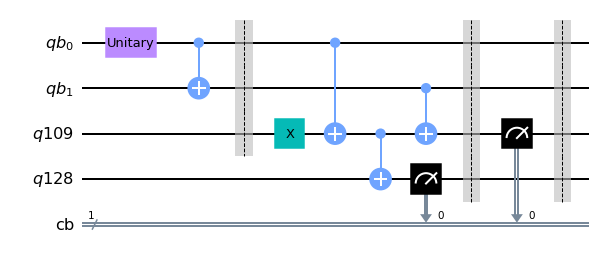

{'1': 1024}


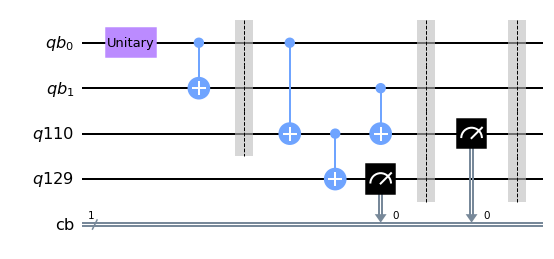

{'0': 1024}


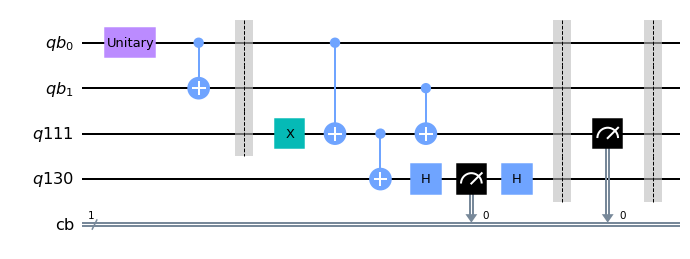

{'1': 1024}


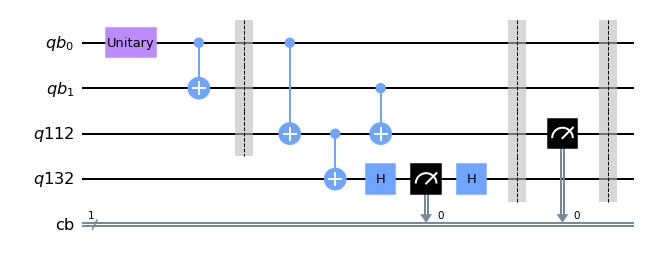

{'0': 1024}


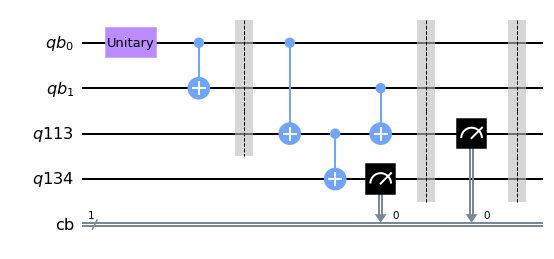

{'0': 1024}


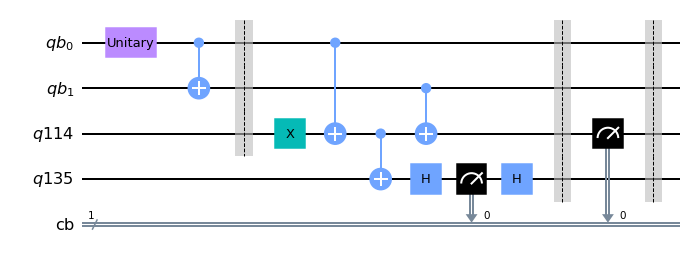

{'1': 1024}


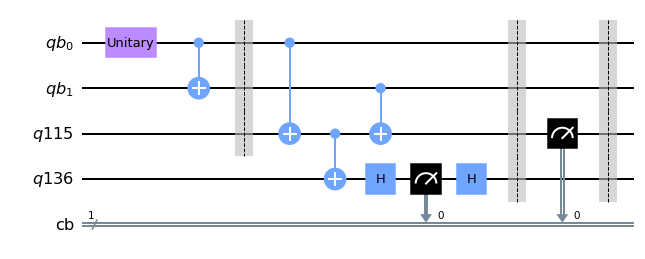

{'0': 1024}


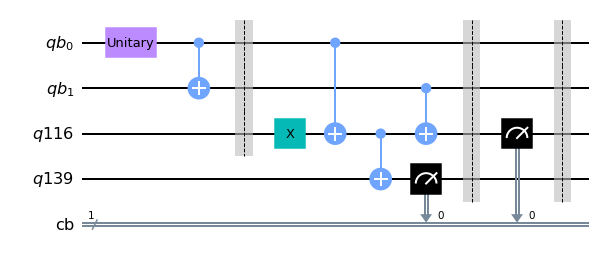

{'1': 1024}


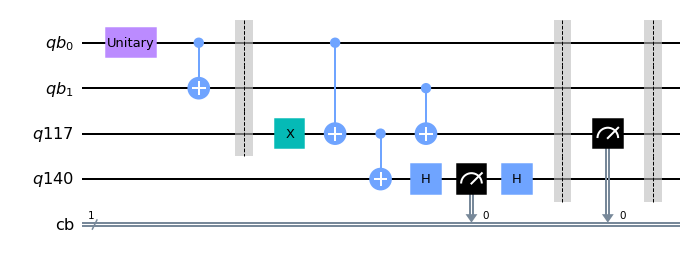

{'1': 1024}


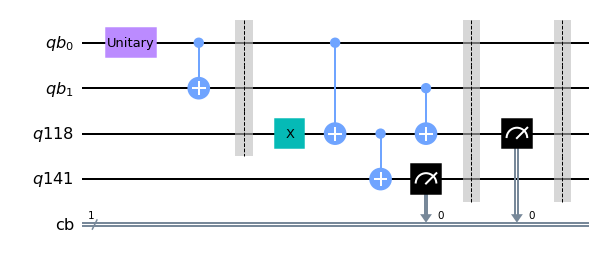

{'1': 1024}


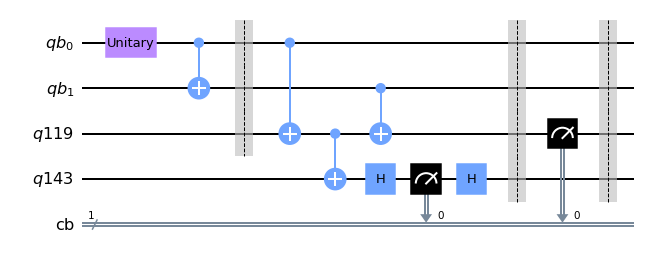

{'0': 1024}


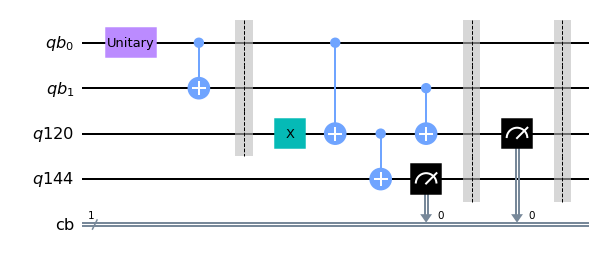

{'1': 1024}


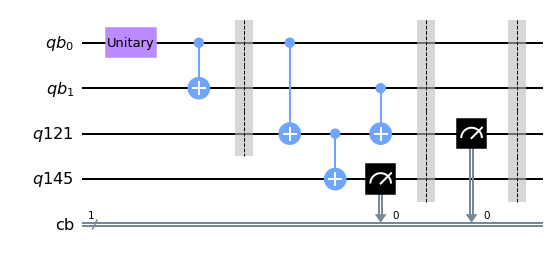

{'0': 1024}


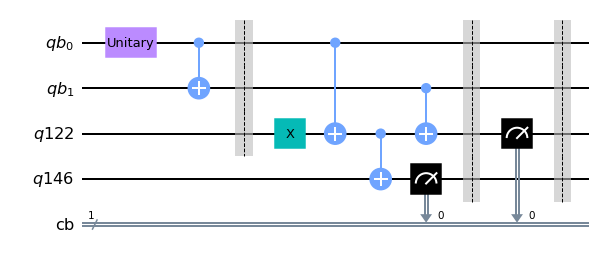

{'1': 1024}


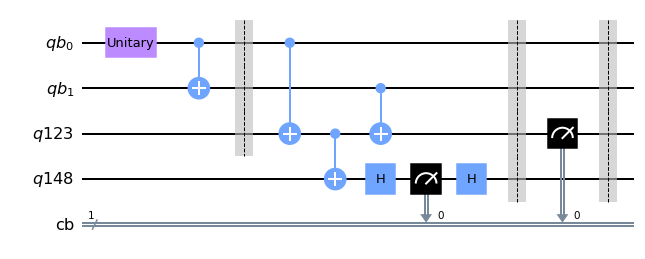

{'0': 1024}
The number of mismatched message photons is 0 and the amount of mismatched message photons:0.0 %
Error rate in measuring message photons: 0.0 %
Time taken to measure 15 message photons: 0 hours 1 minutes 47.59211492538452 seconds


In [26]:
# Measuring the travelling qubit in Z basis

error_lst = []
errors_in_mssg = []


def measure_tq(pk, error_lst, errors_in_mssg, mssg, pos2):
    error = 0
    error_rate = 0.0
    error_in_mssg = 0
    error_in_mssg_rate = 0.0
    result2 = []
    time03 = time.time()
    j = 0
    for i in range(n + nd):
        if i not in pos2:
            pk[i].measure(2, 0)
            pk[i].barrier()
            result = execute(pk[i], backend=sim, shots=shots).result()
            noisy_counts = result.get_counts()
            display(pk[i].draw("mpl"))
            print(noisy_counts)
            res, error, wrong_mssg = cal_error_and_res(noisy_counts, mssg, j)
            error_in_mssg += wrong_mssg
            error_rate = error_rate + float((error / shots) * 100)
            result2.append(res)
            j += 1
    time_3 = time.time() - time03
    hr3 = time_3 // 3600
    time_3 %= 3600
    error_in_mssg_rate = float((error_in_mssg / n) * 100)
    error_rate = float(error_rate / n)
    error_lst.append(error_rate)
    errors_in_mssg.append(error_in_mssg_rate)
    print(
        f"The number of mismatched message photons is {error_in_mssg} and the amount of mismatched message photons:{error_in_mssg_rate} %"
    )
    print(f"Error rate in measuring message photons: {error_rate} %")
    print(
        f"Time taken to measure {n} message photons: {int(hr3)} hours {int(time_3//60)} minutes {time_3%60} seconds"
    )
    return result2


final_res = measure_tq(private_key0, error_lst, errors_in_mssg, message, pos20)